![image.png](attachment:image.png)

# Tarefa - Agrupamento hierárquico

Neste exercício vamos usar a base [online shoppers purchase intention](https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset) de Sakar, C.O., Polat, S.O., Katircioglu, M. et al. Neural Comput & Applic (2018). [Web Link](https://doi.org/10.1007/s00521-018-3523-0).

A base trata de registros de 12.330 sessões de acesso a páginas, cada sessão sendo de um único usuário em um período de 12 meses, para posteriormente estudarmos a relação entre o design da página e o perfil do cliente - "Será que clientes com comportamento de navegação diferentes possuem propensão a compra diferente?"

Nosso objetivo agora é agrupar as sessões de acesso ao portal considerando o comportamento de acesso e informações da data, como a proximidade a uma data especial, fim de semana e o mês.

|Variavel                |Descrição          |
|------------------------|:-------------------|
|Administrative          | Quantidade de acessos em páginas administrativas|
|Administrative_Duration | Tempo de acesso em páginas administrativas |
|Informational           | Quantidade de acessos em páginas informativas  |
|Informational_Duration  | Tempo de acesso em páginas informativas  |
|ProductRelated          | Quantidade de acessos em páginas de produtos |
|ProductRelated_Duration | Tempo de acesso em páginas de produtos |
|BounceRates             | *Percentual de visitantes que entram no site e saem sem acionar outros *requests* durante a sessão  |
|ExitRates               | * Soma de vezes que a página é visualizada por último em uma sessão dividido pelo total de visualizações |
|PageValues              | * Representa o valor médio de uma página da Web que um usuário visitou antes de concluir uma transação de comércio eletrônico |
|SpecialDay              | Indica a proximidade a uma data festiva (dia das mães etc) |
|Month                   | Mês  |
|OperatingSystems        | Sistema operacional do visitante |
|Browser                 | Browser do visitante |
|Region                  | Região |
|TrafficType             | Tipo de tráfego                  |
|VisitorType             | Tipo de visitante: novo ou recorrente |
|Weekend                 | Indica final de semana |
|Revenue                 | Indica se houve compra ou não |

\* variávels calculadas pelo google analytics

In [1]:
!pip install gower

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from gower import gower_matrix

from scipy.spatial.distance  import squareform
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import fcluster

In [39]:
df = pd.read_csv('online_shoppers_intention.csv')

In [24]:
df.head()

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [5]:
df.Revenue.value_counts(dropna=False)

Revenue
False    10422
True      1908
Name: count, dtype: int64

In [6]:
# Exibir a contagem de valores na coluna 'Revenue' em um formato tabular
display(df.Revenue.value_counts(dropna=False).to_frame())


,count
Revenue,
False,10422
True,1908


## Análise descritiva

Faça uma análise descritiva das variáveis do escopo.

- Verifique a distribuição dessas variáveis
- Veja se há valores *missing* e caso haja, decida o que fazer
- Faça mais algum tratamento nas variáveis caso ache pertinente

In [7]:
# Imprimir informações sobre a estrutura do DataFrame
print(f'''
Quantidade de linhas: {df.shape[0]}
Quantidade de colunas: {df.shape[1]}

Quantidade de valores missing: {df.isna().sum().sum()}
''')

# Exibir informações detalhadas sobre o DataFrame,
# incluindo os tipos de dados de cada coluna e a contagem de valores não nulos
df.info()

# Exibir estatísticas descritivas para colunas numéricas do DataFrame
display(df.describe())


Quantidade de linhas: 12330
Quantidade de colunas: 18

Quantidade de valores missing: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null 

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,OperatingSystems,Browser,Region,TrafficType
count,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000,12330.000000
mean,2.315166,80.818611,0.503569,34.472398,31.731468,1194.746220,0.022191,0.043073,5.889258,0.061427,2.124006,2.357097,3.147364,4.069586
std,3.321784,176.779107,1.270156,140.749294,44.475503,1913.669288,0.048488,0.048597,18.568437,0.198917,0.911325,1.717277,2.401591,4.025169
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,7.000000,184.137500,0.000000,0.014286,0.000000,0.000000,2.000000,2.000000,1.000000,2.000000
50%,1.000000,7.500000,0.000000,0.000000,18.000000,598.936905,0.003112,0.025156,0.000000,0.000000,2.000000,2.000000,3.000000,2.000000
75%,4.000000,93.256250,0.000000,0.000000,38.000000,1464.157214,0.016813,0.050000,0.000000,0.000000,3.000000,2.000000,4.000000,4.000000
max,27.000000,3398.750000,24.000000,2549.375000,705.000000,63973.522230,0.200000,0.200000,361.763742,1.000000,8.000000,13.000000,9.000000,20.000000


In [31]:
# retirando as colunas que são do tipo object
df_sem_object = df.select_dtypes(exclude=['object'])

In [32]:
df_sem_object.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 16 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  OperatingSystems         12330 non-null  int64  
 11  Browser                  12330 non-null  int64  
 12  Region                   12330 non-null  int64  
 13  TrafficType              12330 non-null  int64  
 14  Weekend               

<Axes: >

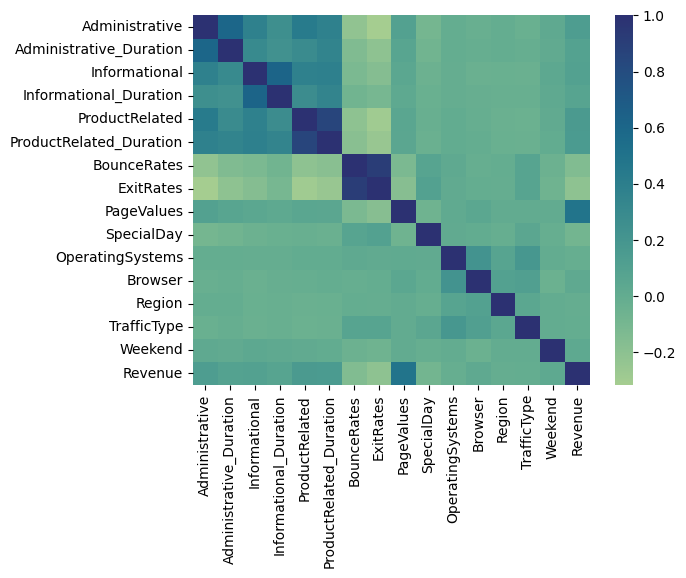

In [35]:
# Criar um mapa de calor (heatmap) para visualizar a correlação entre as colunas do DataFrame
sns.heatmap(df_sem_object.corr(), cmap='crest')

## Variáveis de agrupamento

Liste as variáveis que você vai querer utilizar. Essa é uma atividade importante do projeto, e tipicamente não a recebemos pronta. Não há resposta pronta ou correta, mas apenas critérios e a sua decisão. Os critérios são os seguintes:

- Selecione para o agrupamento variáveis que descrevam o padrão de navegação na sessão.
- Selecione variáveis que indiquem a característica da data.
- Não se esqueça de que você vai precisar realizar um tratamento especial para variáveis qualitativas.
- Trate adequadamente valores faltantes.

In [40]:
# Lista de variáveis que descrevem o padrão de navegação na sessão
session_navigation_pattern = ['Administrative',
                              'Informational',
                              'ProductRelated',
                              'PageValues',
                              'OperatingSystems',
                              'Browser',
                              'TrafficType']

# Obter os tipos de dados das variáveis relacionadas ao padrão de navegação na sessão,
# criar um DataFrame e renomear as colunas
(df[session_navigation_pattern]
 .dtypes
 .reset_index()
 .rename(columns={'index': 'Variável (session_navigation_pattern)',
                  0: 'Tipo'})
)

,Variável (session_navigation_pattern),Tipo
0,Administrative,int64
1,Informational,int64
2,ProductRelated,int64
3,PageValues,float64
4,OperatingSystems,int64
5,Browser,int64
6,TrafficType,int64


In [41]:
# Lista de variáveis que indicam a característica da data
temporal_indicators = ['SpecialDay', 'Month', 'Weekend']

# Obter os tipos de dados das variáveis relacionadas à característica da data,
# criar um DataFrame e renomear as colunas
(df[temporal_indicators]
 .dtypes
 .reset_index()
 .rename(columns={'index': 'Variável (temporal_indicators)',
                  0: 'Tipo'})
)

,Variável (temporal_indicators),Tipo
0,SpecialDay,float64
1,Month,object
2,Weekend,bool


In [42]:
# Lista de variáveis numéricas
numerical = ['ProductRelated', 'PageValues', 'SpecialDay']

# Selecionar as variáveis relacionadas ao padrão de navegação e à característica da data
df_ = df[session_navigation_pattern + temporal_indicators]

# Selecionar as variáveis categóricas removendo as variáveis numéricas
df_cat = df_.drop(columns=numerical)

# Imprimir os valores únicos para cada variável categórica
print('Variáveis Categóricas e seus Valores Únicos:')
[f'{cat}: {df[cat].unique()}' for cat in df_cat]

Variáveis Categóricas e seus Valores Únicos:


['Administrative: [ 0  1  2  4 12  3 10  6  5  9  8 16 13 11  7 18 14 17 19 15 24 22 21 20\n 23 27 26]',
 'Informational: [ 0  1  2  4 16  5  3 14  6 12  7  9 10  8 11 24 13]',
 'OperatingSystems: [1 2 4 3 7 6 8 5]',
 'Browser: [ 1  2  3  4  5  6  7 10  8  9 12 13 11]',
 'TrafficType: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 18 19 16 17 20]',
 "Month: ['Feb' 'Mar' 'May' 'Oct' 'June' 'Jul' 'Aug' 'Nov' 'Sep' 'Dec']",
 'Weekend: [False  True]']

In [43]:
# Criar variáveis dummy para as variáveis relacionadas ao padrão de navegação e à característica da data
df_dummies = pd.get_dummies(data=df_, drop_first=False)

# Obter as colunas que representam as variáveis categóricas
categorical_features = df_dummies.drop(columns=numerical).columns.values

# Criar uma lista de valores booleanos indicando se cada coluna é categórica
cat_features = [True if column in categorical_features else False for column in df_dummies]

# Obter os tipos de dados das variáveis dummy,
# criar um DataFrame e adicionar uma coluna indicando se a variável é categórica
(df_dummies
 .dtypes
 .reset_index()
 .rename(columns={'index': 'Variável',
                  0: 'Tipo'})
 .assign(Categorical=cat_features)
)

,Variável,Tipo,Categorical
0,Administrative,int64,True
1,Informational,int64,True
2,ProductRelated,int64,False
3,PageValues,float64,False
4,OperatingSystems,int64,True
5,Browser,int64,True
6,TrafficType,int64,True
7,SpecialDay,float64,False
8,Weekend,bool,True
9,Month_Aug,bool,True


## Número de grupos

Nesta atividade vamos adotar uma abordagem bem pragmática e avaliar agrupamentos hierárquicos com 3 e 4 grupos, por estarem bem alinhados com uma expectativa e estratégia do diretor da empresa.

*Atenção*: Cuidado se quiser fazer o dendrograma, pois com muitas observações ele pode ser mais complicado de fazer, e dependendo de como for o comando, ele pode travar o *kernell* do seu python.

In [47]:
%%time
# Calcular a matriz de distância Gower
dist_gower = gower_matrix(data_x=df_dummies, cat_features=cat_features)

# Criar um DataFrame com a matriz de distância Gower
pd.DataFrame(dist_gower)

CPU times: user 3min 56s, sys: 1.45 s, total: 3min 57s
Wall time: 4min 2s


,0,1,2,3,4,5,6,7,8,9,...,12320,12321,12322,12323,12324,12325,12326,12327,12328,12329
0,0.000000,0.157969,0.105263,0.157969,0.211198,0.159239,0.178947,0.210601,0.200075,0.179097,...,0.211049,0.158268,0.317357,0.319000,0.264278,0.321453,0.316088,0.316163,0.316835,0.315939
1,0.157969,0.000000,0.157969,0.105263,0.211124,0.053901,0.126390,0.210676,0.094737,0.073759,...,0.158343,0.263457,0.159388,0.213662,0.211571,0.374009,0.263382,0.263457,0.211497,0.210601
2,0.105263,0.157969,0.000000,0.157969,0.211198,0.106607,0.126316,0.263233,0.147443,0.179097,...,0.263680,0.263531,0.317357,0.319000,0.316909,0.321453,0.316088,0.316163,0.316835,0.315939
3,0.157969,0.105263,0.157969,0.000000,0.105860,0.106532,0.179022,0.210676,0.147368,0.179022,...,0.210974,0.263457,0.264651,0.266293,0.264203,0.374009,0.210750,0.210825,0.264128,0.210601
4,0.211198,0.211124,0.211198,0.105860,0.000000,0.211198,0.232251,0.211273,0.253229,0.232102,...,0.315939,0.316088,0.369317,0.370959,0.368869,0.320781,0.210900,0.210825,0.368794,0.211049
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12325,0.321453,0.374009,0.321453,0.374009,0.320781,0.372740,0.395137,0.321527,0.416115,0.394987,...,0.320930,0.321079,0.267253,0.370874,0.372964,0.000000,0.321154,0.321079,0.373039,0.321303
12326,0.316088,0.263382,0.316088,0.210750,0.210900,0.264203,0.337141,0.263531,0.305487,0.336991,...,0.158119,0.210601,0.317059,0.213438,0.211348,0.321154,0.000000,0.052706,0.211273,0.052781
12327,0.316163,0.263457,0.316163,0.210825,0.210825,0.264128,0.337215,0.263606,0.305562,0.337066,...,0.158044,0.210526,0.316984,0.213363,0.211273,0.321079,0.052706,0.000000,0.211198,0.052856
12328,0.316835,0.211497,0.316835,0.264128,0.368794,0.210825,0.285256,0.316909,0.253602,0.285106,...,0.105786,0.211198,0.211049,0.107428,0.157969,0.373039,0.211273,0.211198,0.000000,0.211422


In [50]:
%%time

# Converter a matriz de distância Gower em um vetor
gdv = squareform(X=dist_gower, force='tovector')

# Calcular a matriz de ligação usando o método 'complete'
Z = linkage(y=gdv, method='complete')

# Criar um DataFrame com a matriz de ligação
pd.DataFrame(data=Z, columns=['id1', 'id2', 'dist', 'n'])

CPU times: user 11.8 s, sys: 2 s, total: 13.8 s
Wall time: 15.8 s


,id1,id2,dist,n
0,166.0,167.0,0.000000,2.0
1,64.0,140.0,0.000000,2.0
2,143.0,12331.0,0.000000,3.0
3,10.0,87.0,0.000000,2.0
4,60.0,163.0,0.000000,2.0
...,...,...,...,...
12324,24640.0,24653.0,0.485998,4398.0
12325,24646.0,24651.0,0.488647,4386.0
12326,24654.0,24655.0,0.499902,8784.0
12327,24643.0,24652.0,0.515826,3546.0



3 grupos:
dendrogram.icoord: 123
dendrogram.dcoord: 123
dendrogram.ivl: 124
dendrogram.leaves: 124
dendrogram.color_list: 123
dendrogram.leaves_color_list: 124

4 grupos:
dendrogram.icoord: 123
dendrogram.dcoord: 123
dendrogram.ivl: 124
dendrogram.leaves: 124
dendrogram.color_list: 123
dendrogram.leaves_color_list: 124


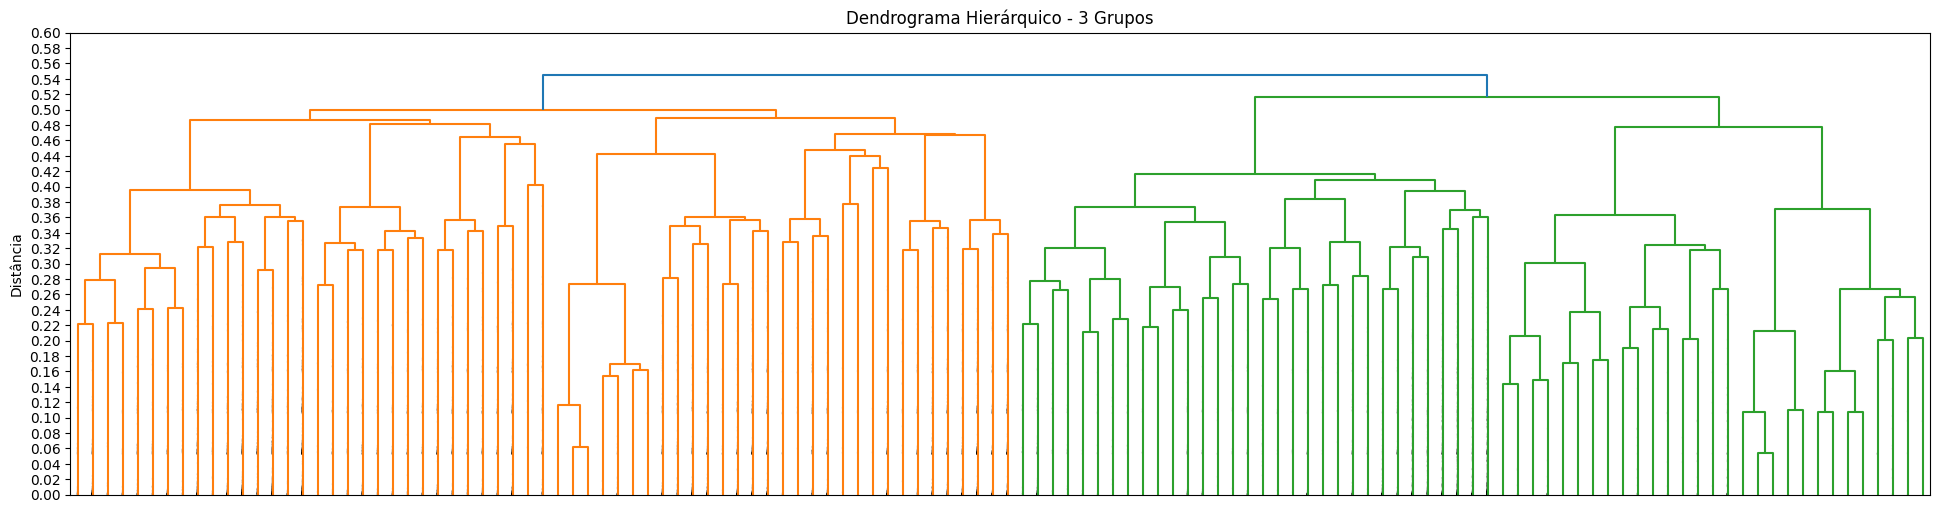

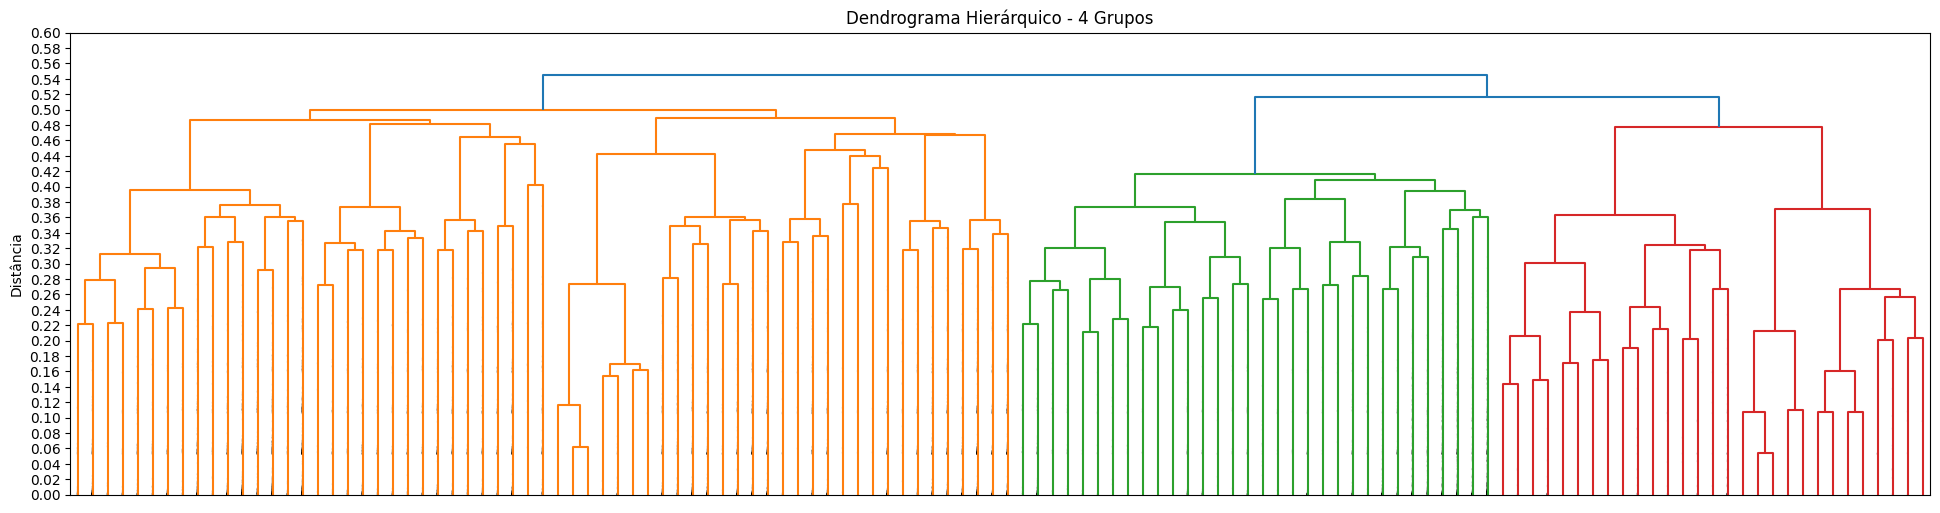

CPU times: user 12.4 s, sys: 418 ms, total: 12.9 s
Wall time: 12.7 s


In [51]:
%%time

# Definir a função para criar um dendrograma
def dn(color_threshold: float, num_groups: int) -> None:
    """
    Cria e exibe um dendrograma.

    Parameters:
        color_threshold (float): Valor de threshold de cor para a coloração do dendrograma.
        num_groups (int): Número de grupos para o título do dendrograma.

    Returns:
        None
    """
    plt.figure(figsize=(24, 6))
    plt.ylabel(ylabel='Distância')

    # Adicionar o número de grupos como título
    plt.title(f'Dendrograma Hierárquico - {num_groups} Grupos')

    # Criar o dendrograma com base na matriz de ligação Z
    dn = dendrogram(Z=Z,
                    p=6,
                    truncate_mode='level',
                    color_threshold=color_threshold,
                    show_leaf_counts=True,
                    leaf_font_size=8,
                    leaf_rotation=45,
                    show_contracted=True)
    plt.yticks(np.linspace(0, .6, num=31))
    plt.xticks([])

    # Imprimir o número de elementos em cada parte do dendrograma
    for i in dn.keys():
        print(f'dendrogram.{i}: {len(dn[i])}')

# Para cada quantidade desejada de grupos e valor de threshold de cor, criar e exibir o dendrograma com título
for qtd, color_threshold in [(3, .53), (4, .5)]:
    print(f'\n{qtd} grupos:')
    dn(color_threshold, qtd)

# Exibir os dendrogramas criados
plt.show()

## Avaliação dos grupos

Construa os agrupamentos com a técnica adequada que vimos em aula. Não se esqueça de tratar variáveis qualitativas, padronizar escalas das quantitativas, tratar valores faltantes e utilizar a distância correta.

Faça uma análise descritiva para pelo menos duas soluções de agrupamentos (duas quantidades diferentes de grupos) sugeridas no item anterior, utilizando as variáveis que estão no escopo do agrupamento.
- Com base nesta análise e nas análises anteriores, decida pelo agrupamento final.
- Se puder, sugira nomes para os grupos.

In [52]:
# Adicionar uma coluna 'grupo_3' ao DataFrame com base no agrupamento hierárquico
df['grupo_3'] = fcluster(Z=Z, t=3, criterion='maxclust')

# Criar um DataFrame contendo a contagem de elementos em cada grupo
(pd.DataFrame({'Grupo': df.grupo_3.value_counts().index,
               'Quantidade': df.grupo_3.value_counts().values})
 .set_index('Grupo')
)

,Quantidade
Grupo,
1,8784
2,3327
3,219


In [53]:
# Criar e exibir uma tabela cruzada normalizada por linha para as variáveis 'VisitorType', 'grupo_3' e 'Revenue'
(pd.crosstab(index=df.VisitorType,
             columns=[df.grupo_3, df.Revenue],
             normalize='index')
 .applymap(lambda x: f'{x*100:.0f} %'))

grupo_3               1           2           3      
Revenue           False True  False True  False True 
VisitorType                                          
New_Visitor        61 %  20 %  13 %   5 %   1 %   0 %
Other              81 %  19 %   0 %   0 %   0 %   0 %
Returning_Visitor  58 %  11 %  26 %   3 %   2 %   0 %

In [56]:
# Criar e exibir uma tabela cruzada normalizada por linha para as variáveis 'Revenue' e 'grupo_3',
# com renomeação dos grupos
(pd.crosstab(index=df.Revenue,
             columns=df.grupo_3,
             normalize='index')
 .applymap(lambda x: f'{x*100:.2f} %')
 .rename(columns={1: '1 (Returning_Visitor)',
                  2: '2 (New_Visitor)',
                  3: '3 (Other)'})
)

grupo_3,1 (Returning_Visitor),2 (New_Visitor),3 (Other)
Revenue,,,
False,69.51 %,28.43 %,2.06 %
True,80.71 %,19.08 %,0.21 %


In [57]:
# Adicionar uma coluna 'grupo_4' ao DataFrame com base no agrupamento hierárquico
df['grupo_4'] = fcluster(Z=Z, t=4, criterion='maxclust')

# Criar um DataFrame contendo a contagem de elementos em cada grupo
(pd.DataFrame({'Grupo': df.grupo_4.value_counts().index,
               'Quantidade': df.grupo_4.value_counts().values})
 .set_index('Grupo')
 .sort_index()
)

,Quantidade
Grupo,
1,4398
2,4386
3,3327
4,219


In [58]:
# Criar e exibir uma tabela cruzada normalizada por coluna para as variáveis 'Month', 'grupo_4' e 'Revenue'
(pd.crosstab(index=df.Month,
             columns=[df.grupo_4, df.Revenue],
             normalize='columns')
 .applymap(lambda x: f'{x*100:.2f} %')
)

grupo_4        1                 2                  3                  4  \
Revenue    False    True     False    True      False     True     False   
Month                                                                      
Aug      10.45 %   7.49 %   0.05 %   0.19 %    0.00 %    0.00 %   0.00 %   
Dec       0.00 %   0.00 %  39.28 %  40.07 %    0.00 %    0.00 %   0.00 %   
Feb       0.06 %   0.00 %   0.03 %   0.00 %    0.00 %    0.00 %  82.79 %   
Jul      10.69 %   6.19 %   0.08 %   0.74 %    0.00 %    0.00 %   0.00 %   
June      0.03 %   0.00 %   6.71 %   5.38 %    0.00 %    0.00 %   0.00 %   
Mar       0.09 %   0.20 %  44.50 %  35.25 %    0.00 %    0.00 %   0.00 %   
May       0.00 %   0.00 %   0.00 %   0.00 %  100.00 %  100.00 %  16.74 %   
Nov      65.71 %  75.72 %   0.16 %   0.37 %    0.00 %    0.00 %   0.00 %   
Oct       2.36 %   1.80 %   9.20 %  18.00 %    0.00 %    0.00 %   0.00 %   
Sep      10.63 %   8.59 %   0.00 %   0.00 %    0.00 %    0.00 %   0.47 %   

grupo_4           
Revenue    True   
Month             
Aug       0.00 %  
Dec       0.00 %  
Feb      75.00 %  
Jul       0.00 %  
June      0.00 %  
Mar       0.00 %  
May      25.00 %  
Nov       0.00 %  
Oct       0.00 %  
Sep       0.00 %

In [59]:
# Criar e exibir uma tabela cruzada normalizada por linha para as variáveis
# 'Revenue', 'VisitorType', 'SpecialDay' e 'grupo_4',
# com renomeação dos grupos
(pd.crosstab(index=[df.Revenue, df.VisitorType, df.SpecialDay],
             columns=df.grupo_4,
             normalize='index')
 .applymap(lambda x: f'{x*100:.2f} %')
 .rename(columns={1: '1 (Returning_Visitor - SpecialDay 0)',
                  2: '2 (Returning_Visitor - SpecialDay 1)',
                  3: '3 (New_Visitor)',
                  4: '4 (Other)'})
)

grupo_4                              1 (Returning_Visitor - SpecialDay 0)  \
Revenue VisitorType       SpecialDay                                        
False   New_Visitor       0.0                                     38.46 %   
                          0.2                                      0.00 %   
                          0.4                                      0.00 %   
                          0.6                                      0.00 %   
                          0.8                                      0.00 %   
                          1.0                                      0.00 %   
        Other             0.0                                     23.19 %   
        Returning_Visitor 0.0                                     36.58 %   
                          0.2                                      0.00 %   
                          0.4                                      0.00 %   
                          0.6                                      0.00 %   
                          0.8                                      0.00 %   
                          1.0                                      0.00 %   
True    New_Visitor       0.0                                     46.55 %   
                          0.2                                      0.00 %   
                          0.4                                      0.00 %   
                          0.6                                      0.00 %   
                          0.8                                      0.00 %   
                          1.0                                      0.00 %   
        Other             0.0                                     12.50 %   
        Returning_Visitor 0.0                                     57.49 %   
                          0.2                                      0.00 %   
                          0.4                                      0.00 %   
                          0.6                                      0.00 %   
                          0.8                                      0.00 %   
                          1.0                                      0.00 %   

grupo_4                              2 (Returning_Visitor - SpecialDay 1)  \
Revenue VisitorType       SpecialDay                                        
False   New_Visitor       0.0                                     46.10 %   
                          0.2                                      0.00 %   
                          0.4                                      0.00 %   
                          0.6                                      0.00 %   
                          0.8                                      0.00 %   
                          1.0                                      0.00 %   
        Other             0.0                                     76.81 %   
        Returning_Visitor 0.0                                     40.60 %   
                          0.2                                      0.00 %   
                          0.4                                      0.00 %   
                          0.6                                      0.00 %   
                          0.8                                      0.00 %   
                          1.0                                      0.00 %   
True    New_Visitor       0.0                                     35.71 %   
                          0.2                                      0.00 %   
                          0.4                                      0.00 %   
                          0.6                                      0.00 %   
                          0.8                                      0.00 %   
                          1.0                                      0.00 %   
        Other             0.0                                     87.50 %   
        Returning_Visitor 0.0                                     26.97 %   
                          0.2                                      0.00 

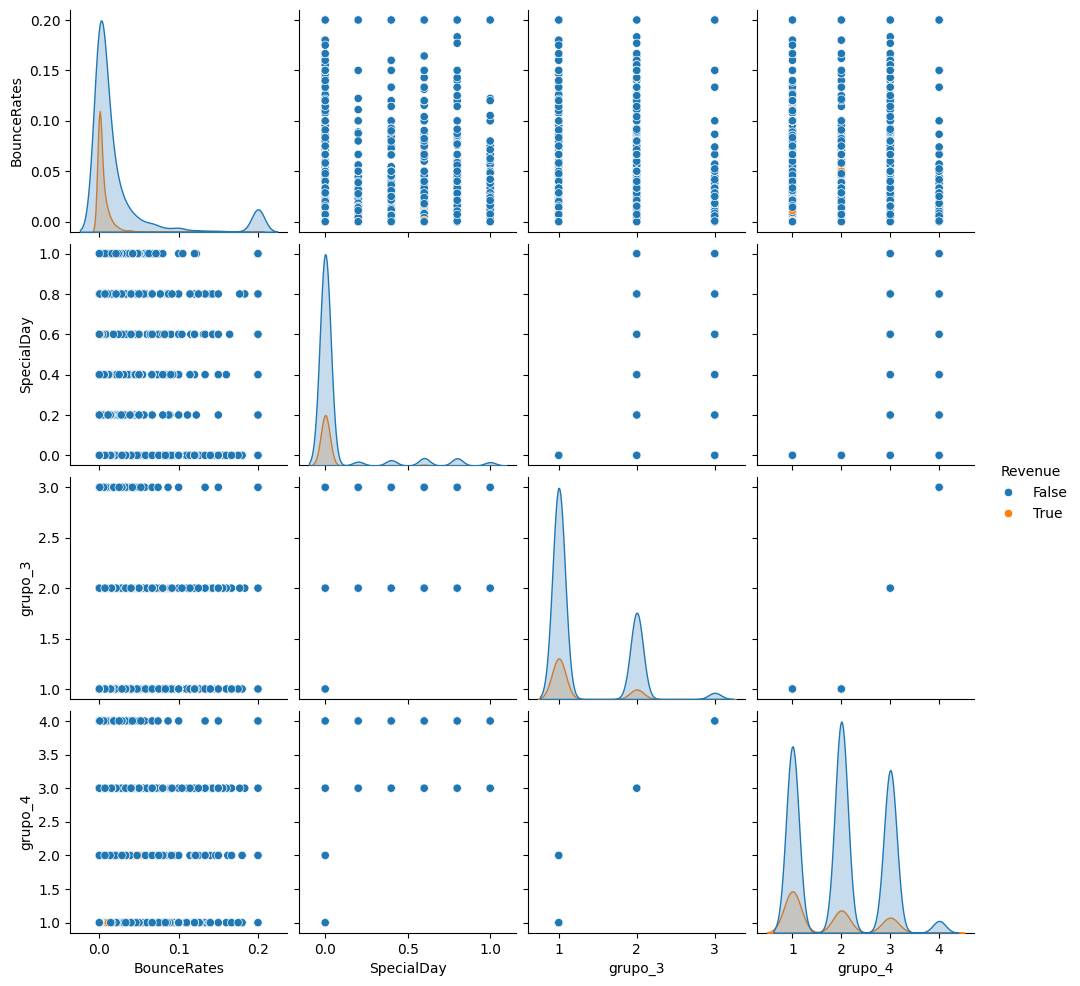

In [60]:
# Criar um pair plot para visualizar as relações entre as variáveis
# 'BounceRates', 'Revenue', 'SpecialDay', 'grupo_3' e 'grupo_4',
# colorindo pelo valor da variável 'Revenue'
sns.pairplot(data=df[['BounceRates', 'Revenue', 'SpecialDay', 'grupo_3', 'grupo_4']], hue='Revenue')

# Exibir o pair plot
plt.show()

## Avaliação de resultados

Avalie os grupos obtidos com relação às variáveis fora do escopo da análise (minimamente *bounce rate* e *revenue*).
- Qual grupo possui clientes mais propensos à compra?

O grupo 1, composto por visitantes recorrentes nos mostra que estes são os mais propensos à compra, devido as análises de tempo e de navegação.